<a href="https://colab.research.google.com/github/kernelphan/ML-DL-Project/blob/main/Prediction%20of%20Course%20Selection%20Behavior%20of%20Information%20Technology%20Students%20at%20IUH%20University.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bài tập thường kỳ 2. Dự đoán nhãn cho bình luận

Import data

In [ ]:
pip install transformers torch

In [ ]:
!pip install wordcloud

In [ ]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
import re
import string

from underthesea import word_tokenize, text_normalize


import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:

file_path = '/content/drive/MyDrive/DEEP LEARNING/BaiTapThuongKy2/data_final.xlsx'
data = pd.read_excel(file_path)

Show data ban đầu

In [ ]:
data.head()

,Unnamed: 0,old_data,label
0,0,"Shop giao sản phẩm đã qua sử dụng , không hài ...",0
1,1,"Đóng gói cẩn thận, sp mới và nhỏ gọn. Rất hài ...",4
2,2,"Sản phẩm nhỏ gọn, giao hàng rất nhanh.",1
3,3,sản phẩm rất chuẩn so vs quảng cáo.,1
4,4,Nhỏ gọn gê,1


Drop cột STT

In [ ]:
# Dropping the first column (index column) by referencing its name or position
data = data.drop(columns=[data.columns[0]])

# Display the first few rows to confirm
data.head()


,old_data,label
0,"Shop giao sản phẩm đã qua sử dụng , không hài ...",0
1,"Đóng gói cẩn thận, sp mới và nhỏ gọn. Rất hài ...",4
2,"Sản phẩm nhỏ gọn, giao hàng rất nhanh.",1
3,sản phẩm rất chuẩn so vs quảng cáo.,1
4,Nhỏ gọn gê,1


số lượng cmt theo rate label

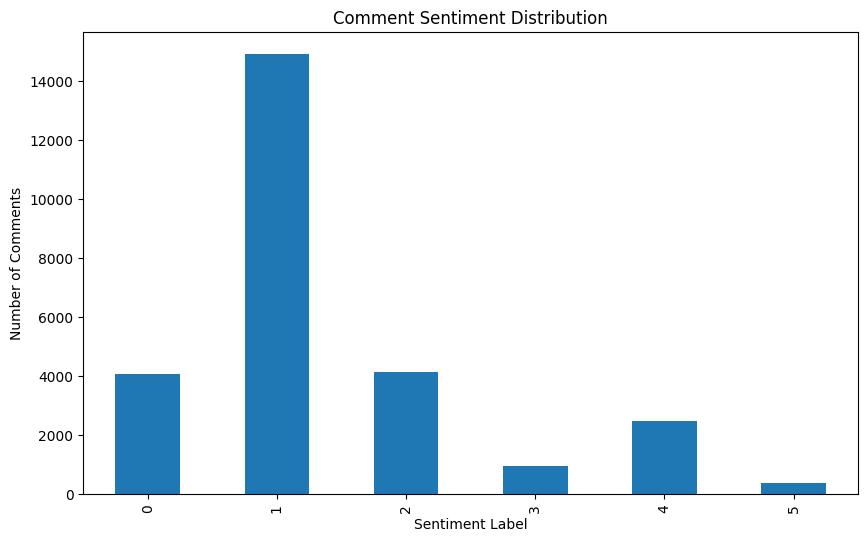

In [ ]:

# Count of each sentiment label
label_counts = data['label'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Comment Sentiment Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Comments')
plt.show()


Tỷ lệ của các rate label

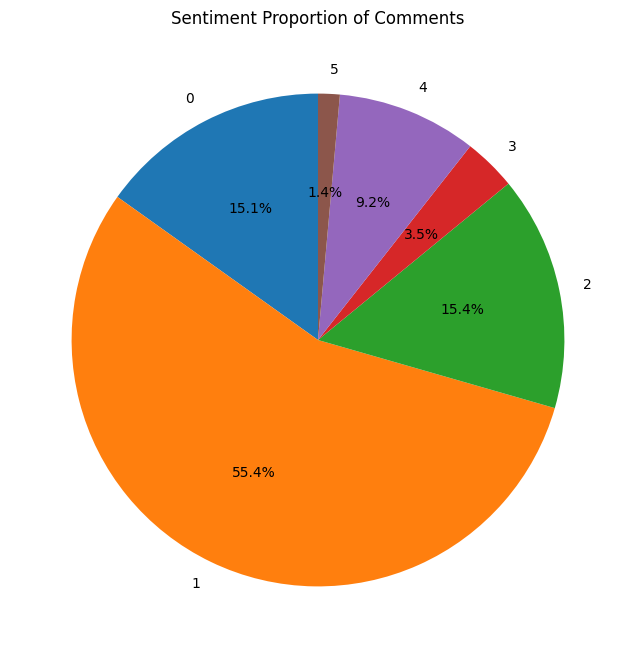

In [ ]:
plt.figure(figsize=(8, 8))
label_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Proportion of Comments')
plt.ylabel('')
plt.show()


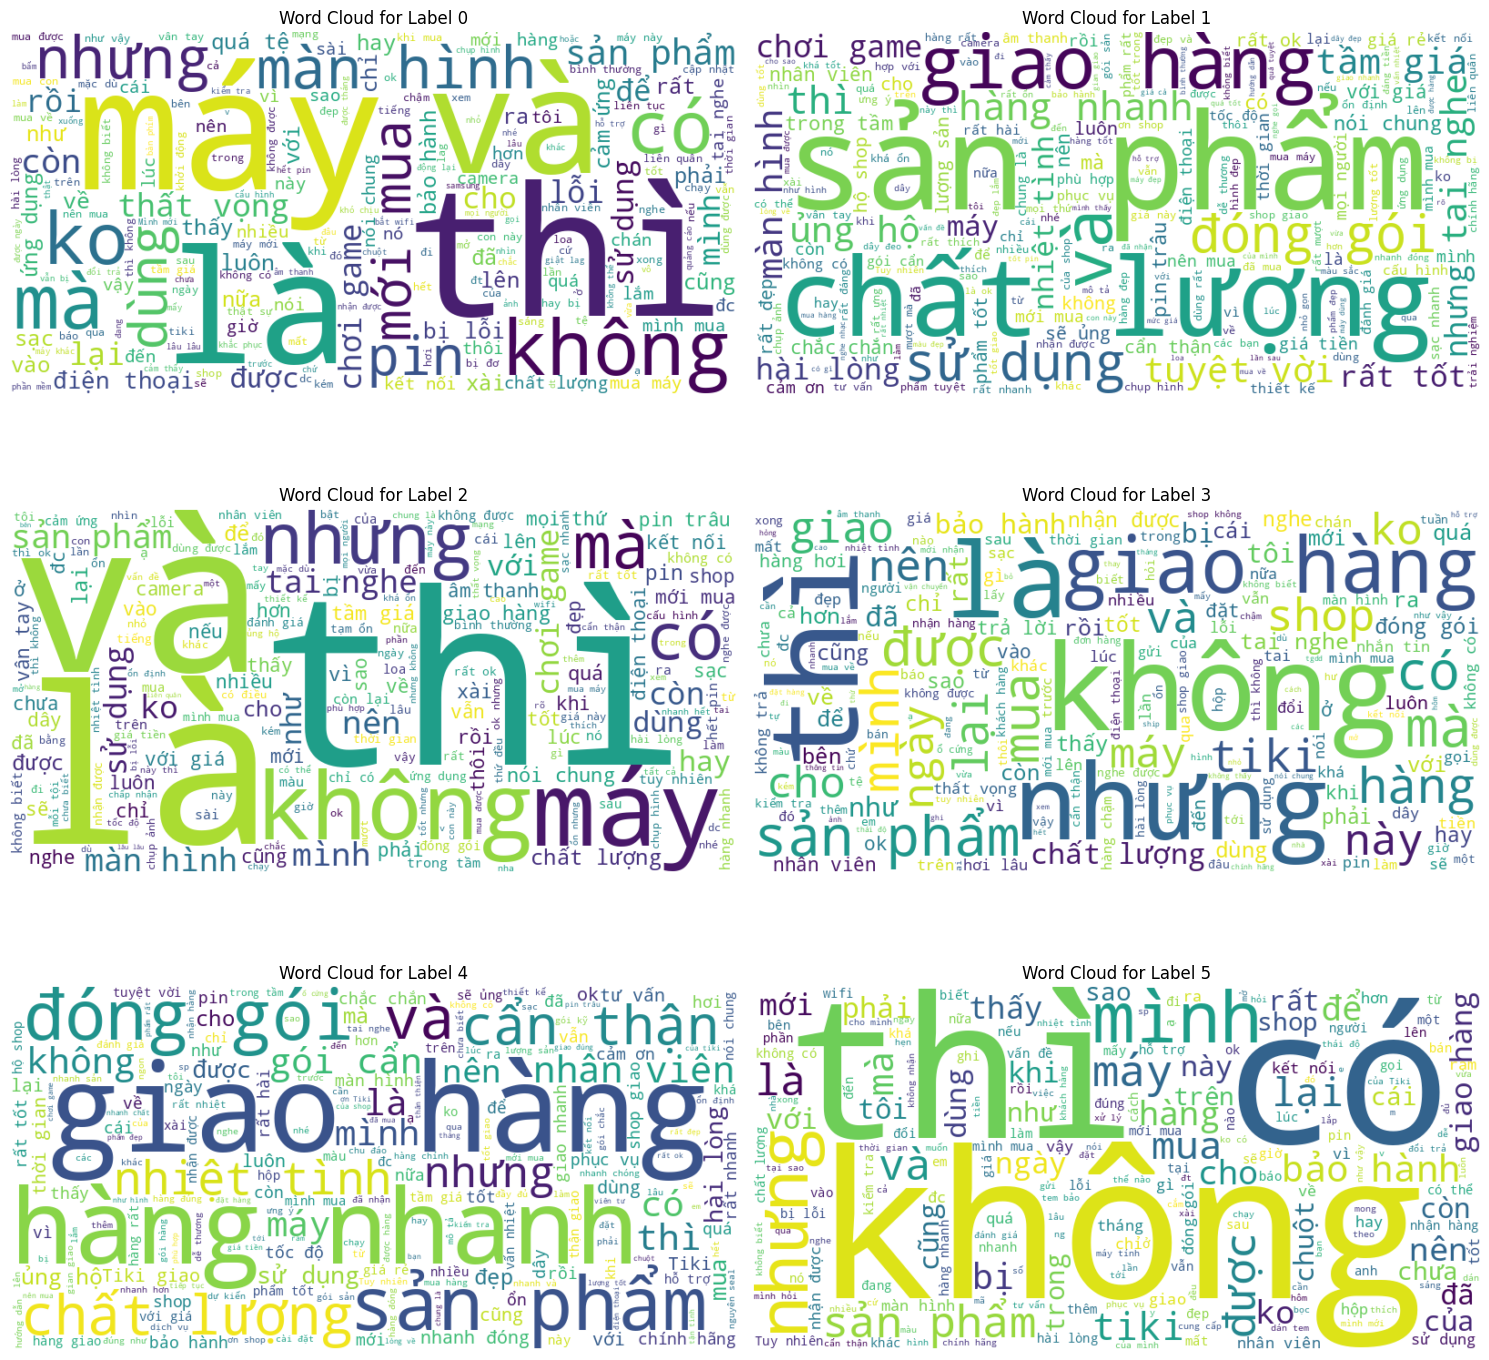

In [ ]:


# Ensure 'label' column contains 6 unique labels
unique_labels = sorted(data['label'].unique())[:6]  # Sorting and taking the first 6 if more are present

# Set up the figure for displaying multiple word clouds
plt.figure(figsize=(15, 15))
for i, label in enumerate(unique_labels, 1):
    # Filter comments for the current label
    comments = ' '.join(data[data['label'] == label]['old_data'].astype(str))
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)

    # Plot each word cloud
    plt.subplot(3, 2, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Label {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


Remove .....

In [ ]:


# Giả sử 'old_data' là cột chứa bình luận trong DataFrame data
# Xóa những câu có nhiều dấu chấm liên tiếp
data = data[~data['old_data'].str.contains(r'\.{3,}', na=False)]

# Kiểm tra lại kết quả
data.head()


,old_data,label
0,"Shop giao sản phẩm đã qua sử dụng , không hài ...",0
1,"Đóng gói cẩn thận, sp mới và nhỏ gọn. Rất hài ...",4
2,"Sản phẩm nhỏ gọn, giao hàng rất nhanh.",1
3,sản phẩm rất chuẩn so vs quảng cáo.,1
4,Nhỏ gọn gê,1


Remove stop words, convert to lowercase

In [ ]:
# List of common Vietnamese stop words
vietnamese_stop_words = [
    "và", "là", "của", "có", "một", "những", "các", "được", "trong", "với",
    "cho", "đã", "này", "nên", "ra", "về", "thì", "làm", "không", "tại",
    "như", "lại", "nhưng", "đó", "để", "cũng", "theo", "nếu", "khi", "qua",
    "rằng", "đi", "sau", "hơn", "nhiều", "rất", "gì", "đang", "cùng", "bởi"
]

def remove_vietnamese_stop_words(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove Vietnamese stop words
    words = text.split()
    words = [word for word in words if word not in vietnamese_stop_words]

    # Join words back into one string
    cleaned_text = ' '.join(words)

    return cleaned_text

# Apply this to the 'old_data' column
data['old_data'] = data['old_data'].astype(str).apply(remove_vietnamese_stop_words)

# Display the first few rows to verify the results
data.head()


,old_data,label
0,shop giao sản phẩm sử dụng hài lòng sản phẩm,0
1,đóng gói cẩn thận sp mới nhỏ gọn hài lòng cám ...,4
2,sản phẩm nhỏ gọn giao hàng nhanh,1
3,sản phẩm chuẩn so vs quảng cáo,1
4,nhỏ gọn gê,1


remove emoji, repeat char

In [ ]:
emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"
                u"\U0001F300-\U0001F5FF"
                u"\U0001F680-\U0001F6FF"
                u"\U0001F1E0-\U0001F1FF"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE) # Unicode emojis.

def clean_text(text):

    text = re.sub(emoji_pattern, " ", text) # remove emojis

    text = re.sub(r'([a-z]+?)\1+',r'\1', text) # reduce repeated character (e.g. 'aaabbb' -> 'ab')

    # Ensure space before and after any punctuation mark
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)

    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+",r"\1", text) # reduce consecutive punctuation

    # Xóa mọi dấu cách ở đầu hoặc cuối hoặc dấu chấm câu ở đầu hoặc cuối khỏi văn bản
    text = text.strip()
    while text.endswith(tuple(string.punctuation+string.whitespace)):
        text = text[:-1]
    while text.startswith(tuple(string.punctuation+string.whitespace)):
        text = text[1:]

    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuation

    text = re.sub(r"\s+", " ", text) # reduce multiple spaces

    text = text_normalize(text) # make sure punctunation is in the right letter (Vietnamese case)
    text = word_tokenize(text, format="text") # tokenize the cleaned text
    # text = unidecode(text) # remove accent marks from sentences (no significant difference when accent marks is removed or kept)

    '''
    Proper tokenization allows models or algorithms to understand the semantics of the text better.
    For instance, `"đi chơi" (go play)` should be treated as one unit
    instead of two separate words "đi" (go) and "chơi" (play) for proper semantic understanding.
    '''
    return text

# Apply this to the 'old_data' column
data['old_data'] = data['old_data'].apply(clean_text)

# Display the first few rows to verify the results
data.head()

,old_data,label
0,shop giao sản_phẩm sử_dụng hài_lòng sản_phẩm,0
1,đóng_gói cẩn_thận sp mới nhỏ gọn hài_lòng cám_...,4
2,sản_phẩm nhỏ gọn giao hàng nhanh,1
3,sản_phẩm chuẩn so vs quảng_cáo,1
4,nhỏ gọn gê,1


teen code

In [ ]:

# Tạo từ điển teen code phổ biến
teen_code_dict = {
    'k0': 'không', 'hok': 'không', 'ko': 'không', 'kh': 'không', 'k': 'không',
    'dc': 'được', 'j': 'gì', 'ck': 'chồng', 'vk': 'vợ', 'mk': 'mình',
    'mjk': 'mình', 'u': 'you', 'iu': 'yêu', 'z': 'd', 'vs': 'với',
    'ntn': 'như thế nào', 'ahihi': 'haha', 'vl': 'vãi', 'bt': 'bình thường',
    'cc':'tệ', 'gê':'ghê','sp':'sản phẩm'

}

def convert_teen_code(text):
    # Tách các từ trong văn bản
    words = text.split()
    # Thay thế các từ teen code bằng từ chuẩn
    converted_words = [teen_code_dict.get(word, word) for word in words]
    # Ghép lại thành câu đã chuyển đổi
    return ' '.join(converted_words)


data['old_data'] = data['old_data'].apply(convert_teen_code)

# Hiển thị kết quả
data.head()


,old_data,label
0,shop giao sản_phẩm sử_dụng hài_lòng sản_phẩm,0
1,đóng_gói cẩn_thận sản phẩm mới nhỏ gọn hài_lòn...,4
2,sản_phẩm nhỏ gọn giao hàng nhanh,1
3,sản_phẩm chuẩn so với quảng_cáo,1
4,nhỏ gọn ghê,1


In [ ]:
# data.to_excel('/content/drive/MyDrive/DEEP LEARNING/BaiTapThuongKy2/processed_data.xlsx', index=False)
# !cp '/content/processed_data.xlsx' '/content/drive/MyDrive/'
hienthi=pd.read_excel('/content/drive/MyDrive/DEEP LEARNING/BaiTapThuongKy2/processed_data.xlsx')
hienthi.head()

,old_data,label
0,shop giao sản_phẩm sử_dụng hài_lòng sản_phẩm,0
1,đóng_gói cẩn_thận sản phẩm mới nhỏ gọn hài_lòn...,4
2,sản_phẩm nhỏ gọn giao hàng nhanh,1
3,sản_phẩm chuẩn so với quảng_cáo,1
4,nhỏ gọn ghê,1


Chia data ra tap train, valid, test theo từng label

In [ ]:
from sklearn.model_selection import train_test_split

# Giả sử cột 'label' chứa các nhãn và cột 'old_data' chứa văn bản
texts = data['old_data'].tolist()
labels = data['label'].tolist()

# Bước 1: Chia dữ liệu thành 70% huấn luyện và 30% tạm thời
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.3, stratify=labels, random_state=42
)

# Bước 2: Chia tập tạm thời thành 50% để lấy 15% cho tập xác thực và 15% cho tập kiểm tra
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Kiểm tra số lượng mẫu trong từng tập
print("Số lượng mẫu trong tập huấn luyện:", len(train_texts))
print("Số lượng mẫu trong tập xác thực:", len(val_texts))
print("Số lượng mẫu trong tập kiểm tra:", len(test_texts))


Số lượng mẫu trong tập huấn luyện: 18108
Số lượng mẫu trong tập xác thực: 3880
Số lượng mẫu trong tập kiểm tra: 3881


Phân phối các nhãn trong train,valid,test

In [ ]:


# Chuyển đổi các tập thành DataFrame để dễ kiểm tra
train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
val_df = pd.DataFrame({'text': val_texts, 'label': val_labels})
test_df = pd.DataFrame({'text': test_texts, 'label': test_labels})

# Kiểm tra phân phối nhãn
print("Phân phối nhãn trong tập huấn luyện:\n", train_df['label'].value_counts(normalize=True))
print("Phân phối nhãn trong tập xác thực:\n", val_df['label'].value_counts(normalize=True))
print("Phân phối nhãn trong tập kiểm tra:\n", test_df['label'].value_counts(normalize=True))


Phân phối nhãn trong tập huấn luyện:
 label
1    0.554016
2    0.154005
0    0.151404
4    0.091787
3    0.034613
5    0.014174
Name: proportion, dtype: float64
Phân phối nhãn trong tập xác thực:
 label
1    0.554124
2    0.153827
0    0.151350
4    0.091652
3    0.034679
5    0.014367
Name: proportion, dtype: float64
Phân phối nhãn trong tập kiểm tra:
 label
1    0.554124
2    0.154075
0    0.151350
4    0.091900
3    0.034432
5    0.014119
Name: proportion, dtype: float64


In [ ]:



# Sử dụng CountVectorizer
count_vectorizer = CountVectorizer(max_features=5000)  # Sử dụng tối đa 5000 từ phổ biến nhất
X_count = count_vectorizer.fit_transform(data['cleaned_text'])

# Sử dụng TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Sử dụng tối đa 5000 từ phổ biến nhất
X_tfidf = tfidf_vectorizer.fit_transform(data['cleaned_text'])

# Kiểm tra kết quả
print("Dạng CountVectorizer:")
print(X_count.toarray())
print("Dạng TfidfVectorizer:")
print(X_tfidf.toarray())


Dạng CountVectorizer:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Dạng TfidfVectorizer:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Bước 1: Chuẩn bị dữ liệu
X = data['old_data']  # Dữ liệu đầu vào là các bình luận
y = data['label']     # Nhãn đầu ra

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bước 2: Xử lý văn bản
vectorizer = TfidfVectorizer(max_features=5000)  # Sử dụng tối đa 5000 từ
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Bước 3: Huấn luyện mô hình
model = LogisticRegression()
model.fit(X_train_vec, y_train)

# Bước 4: Dự đoán và đánh giá
y_pred = model.predict(X_test_vec)

# Đánh giá hiệu quả của mô hình
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Tải tokenizer và mô hình PhoBERT

In [ ]:

# Load PhoBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=len(set(train_labels)))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize dữ liệu
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Tạo Dataset class để đưa vào DataLoader
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Tạo dataset cho tập huấn luyện và tập validation
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)


In [ ]:
# Thiết lập tham số huấn luyện
training_args = TrainingArguments(
    output_dir='./results',          # Thư mục lưu kết quả
    num_train_epochs=5,              # Số lượng epoch
    per_device_train_batch_size=4,   # Batch size cho huấn luyện
    per_device_eval_batch_size=4,    # Batch size cho kiểm tra
    warmup_steps=500,                # Số bước warmup
    weight_decay=0.01,               # Trọng số weight decay
    logging_dir='./logs',            # Thư mục lưu logs
    logging_steps=10,
    evaluation_strategy="epoch"      # Kiểm tra sau mỗi epoch
)

# Khởi tạo Trainer
trainer = Trainer(
    model=model,                         # Mô hình PhoBERT
    args=training_args,                  # Tham số huấn luyện
    train_dataset=train_dataset,         # Tập huấn luyện
    eval_dataset=val_dataset             # Tập kiểm tra
)

# Huấn luyện mô hình
trainer.train()
history = trainer.state.log_history

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss


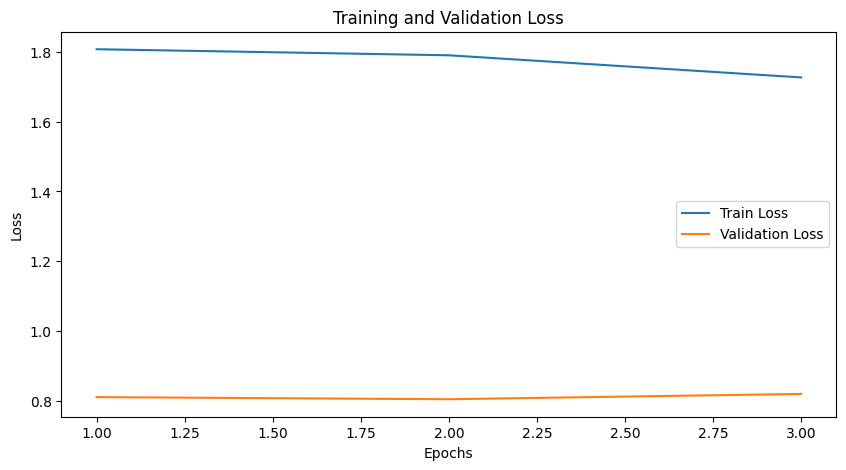

In [ ]:
# Lấy các giá trị loss và eval_loss
train_loss = [log["loss"] for log in history if "loss" in log]
eval_loss = [log["eval_loss"] for log in history if "eval_loss" in log]
epochs = list(range(1, len(eval_loss) + 1))
# Vẽ đồ thị loss của train và validation
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss[:len(eval_loss)], label='Train Loss')
plt.plot(epochs, eval_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")


In [ ]:
# Đảm bảo mô hình ở chế độ đánh giá
model.eval()

# Di chuyển model đến GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Chia test_encodings thành các batch nhỏ hơn
batch_size = 32 # Adjust this value as needed
num_batches = len(test_encodings['input_ids']) // batch_size + (len(test_encodings['input_ids']) % batch_size > 0)

predictions = []
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(test_encodings['input_ids']))

    batch_encodings = {k: v[start_idx:end_idx].to(device) for k, v in test_encodings.items()}

    # Dự đoán
    with torch.no_grad():
        outputs = model(**batch_encodings)
        batch_predictions = torch.argmax(outputs.logits, dim=1).tolist()
        predictions.extend(batch_predictions)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Tính accuracy
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy:", accuracy)

# Báo cáo chi tiết
print("Classification Report:\n", classification_report(test_labels, predictions))


Accuracy: 0.6985313063643391
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.69      0.68       571
           1       0.82      0.83      0.83      2169
           2       0.49      0.48      0.48       593
           3       0.39      0.34      0.36       136
           4       0.46      0.50      0.48       357
           5       0.33      0.13      0.18        55

    accuracy                           0.70      3881
   macro avg       0.53      0.49      0.50      3881
weighted avg       0.69      0.70      0.70      3881



In [ ]:
!cp -r /content/ '/content/drive/MyDrive/DEEP LEARNING/BaiTapThuongKy2'


cp: cannot create directory '/content/drive/MyDrive/DEEP LEARNING/BaiTapThuongKy2/content/drive/.Encrypted/MyDrive/DEEP LEARNING/BaiTapThuongKy2/content/drive/.Encrypted/MyDrive/DEEP LEARNING/BaiTapThuongKy2/content/drive/.Encrypted/MyDrive/DEEP LEARNING/BaiTapThuongKy2/content/drive/.Encrypted/MyDrive/DEEP LEARNING/BaiTapThuongKy2/content/drive/.Encrypted/MyDrive/DEEP LEARNING/BaiTapThuongKy2/content/drive/.Encrypted/MyDrive/DEEP LEARNING/BaiTapThuongKy2/content/drive/.Encrypted/MyDrive/DEEP LEARNING/BaiTapThuongKy2/content/drive/.Encrypted/MyDrive/DEEP LEARNING/BaiTapThuongKy2/content/drive/.Encrypted/MyDrive/DEEP LEARNING/BaiTapThuongKy2/content/drive/.Encrypted/MyDrive/DEEP LEARNING/BaiTapThuongKy2/content/drive/.Encrypted/MyDrive/DEEP LEARNING/BaiTapThuongKy2/content/drive/.Encrypted/MyDrive/DEEP LEARNING/BaiTapThuongKy2/content/drive/.Encrypted/MyDrive/DEEP LEARNING/BaiTapThuongKy2/content/drive/.Encrypted/MyDrive/DEEP LEARNING/BaiTapThuongKy2/content/drive/.Encrypted/MyDrive/DEE